Plotting transformed images for class: Powdery mildew
Plotting transformed images for class: Healthy
Plotting transformed images for class: Cotton Boll Rot
Plotting transformed images for class: Bacterial blight
Plotting transformed images for class: Aphids


C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\dell/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [00:16<00:00, 33.0MB/s]


Epoch 1/250 - Loss: 1.1205 Acc: 0.6021
Epoch 2/250 - Loss: 0.7949 Acc: 0.7278
Epoch 3/250 - Loss: 0.7180 Acc: 0.7497
Epoch 4/250 - Loss: 0.6596 Acc: 0.7714
Epoch 5/250 - Loss: 0.6325 Acc: 0.7785
Epoch 6/250 - Loss: 0.6057 Acc: 0.7909
Epoch 7/250 - Loss: 0.5989 Acc: 0.7868
Epoch 8/250 - Loss: 0.5945 Acc: 0.7933
Epoch 9/250 - Loss: 0.5874 Acc: 0.7968
Epoch 10/250 - Loss: 0.5705 Acc: 0.8048
Epoch 11/250 - Loss: 0.5632 Acc: 0.8046
Epoch 12/250 - Loss: 0.5512 Acc: 0.8037
Epoch 13/250 - Loss: 0.5796 Acc: 0.7986
Epoch 14/250 - Loss: 0.5796 Acc: 0.7980
Epoch 15/250 - Loss: 0.5601 Acc: 0.8033
Epoch 16/250 - Loss: 0.5718 Acc: 0.8033
Epoch 17/250 - Loss: 0.5634 Acc: 0.8037
Epoch 18/250 - Loss: 0.5532 Acc: 0.8054
Epoch 19/250 - Loss: 0.5675 Acc: 0.8052
Epoch 20/250 - Loss: 0.5559 Acc: 0.8079
Epoch 21/250 - Loss: 0.5380 Acc: 0.8135
Epoch 22/250 - Loss: 0.5302 Acc: 0.8150
Epoch 23/250 - Loss: 0.5285 Acc: 0.8226
Epoch 24/250 - Loss: 0.5265 Acc: 0.8209
Epoch 25/250 - Loss: 0.5366 Acc: 0.8144
Epoch 26/

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Cotton-Disease-Training\\trainning\\cotton_segment.jpg'

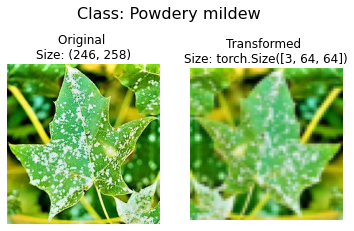

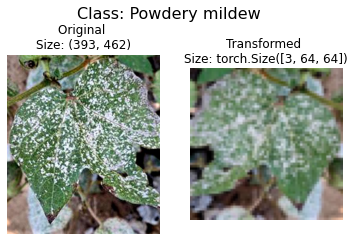

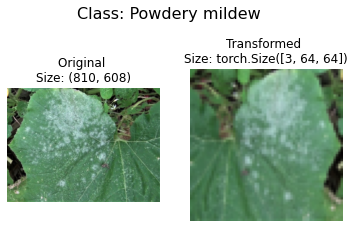

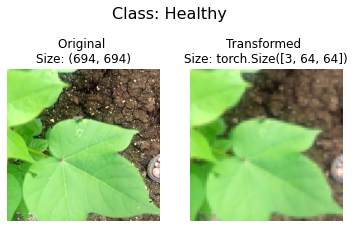

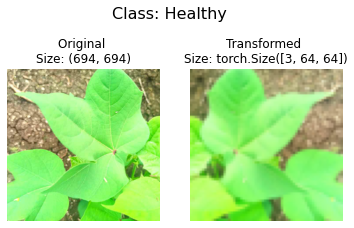

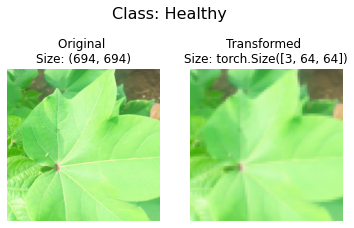

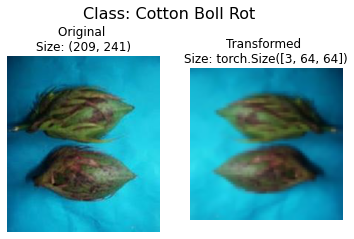

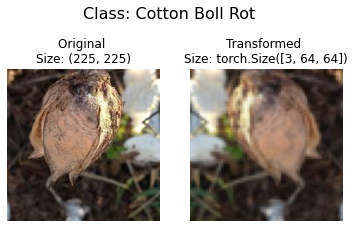

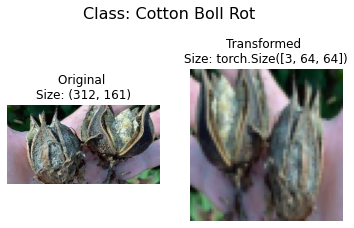

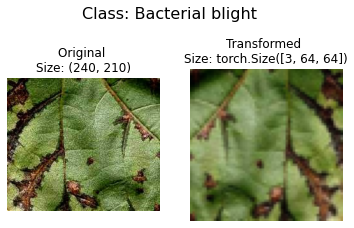

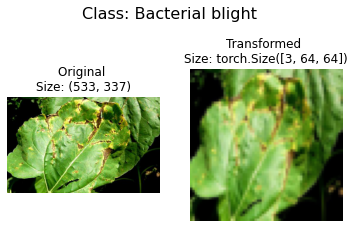

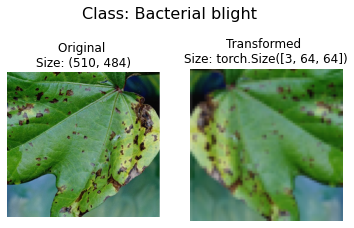

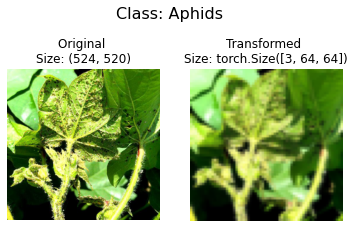

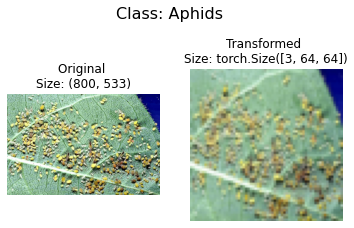

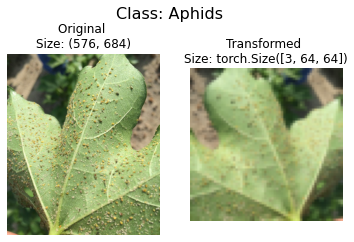

In [7]:
import time

# Record the start time
start_time = time.time()
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original \nSize: {img.size}")
            ax[0].axis("off")

            transformed_image = transform(img)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            class_name = os.path.basename(os.path.dirname(image_path))
            fig.suptitle(f"Class: {class_name}", fontsize=16)

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

main_folder = "E:\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images"


classes = ["Powdery mildew", "Healthy", "Cotton Boll Rot", "Bacterial blight", "Aphids"]
class_to_idx = {cls: i for i, cls in enumerate(classes)}

class_images = {cls: [] for cls in classes}

for cls in classes:
    class_folder = os.path.join(main_folder, cls)
    for filename in os.listdir(class_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_folder, filename)
            class_images[cls].append(img_path)

image_path_list = {cls: images for cls, images in class_images.items()}

for cls in classes:
    print(f"Plotting transformed images for class: {cls}")
    plot_transformed_images(image_path_list[cls], transform=data_transform, n=3)

train_data = datasets.ImageFolder(root=main_folder, transform=data_transform)
class_names = train_data.classes

train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[6].requires_grad = True
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

num_epochs = 250
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = corrects.double() / len(train_data)

    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Save the fine-tuned model (with the weights that we want)
torch.save(model.state_dict(), "first_tuned_model_cotton_disease.pth")

# Testing phase
test_image_path = "E:\\Cotton-Disease-Training\\trainning\\cotton_segment.jpg"
test_image = Image.open(test_image_path)

data_transform_test = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

transformed_test_image = data_transform_test(test_image)
transformed_test_image = transformed_test_image.unsqueeze(0)

# Create a new model for testing
model_test = models.vgg16(pretrained=False)
num_ftrs_test = model_test.classifier[6].in_features
model_test.classifier[6] = nn.Linear(num_ftrs_test, len(class_names))  # Ensure the number of classes matches the original configuration
model_test.load_state_dict(torch.load("first_tuned_model_cotton_disease.pth"))
model_test.eval()
transformed_test_image = transformed_test_image.to(device)
model_test = model_test.to(device)

with torch.no_grad():
    outputs_test = model_test(transformed_test_image)
    _, predicted_test = torch.max(outputs_test, 1)

predicted_class_test = class_names[predicted_test.item()]
print(f"The image is classified as class: {predicted_class_test}")


# Your code block here
# ...

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Execution time: {elapsed_time} seconds")
